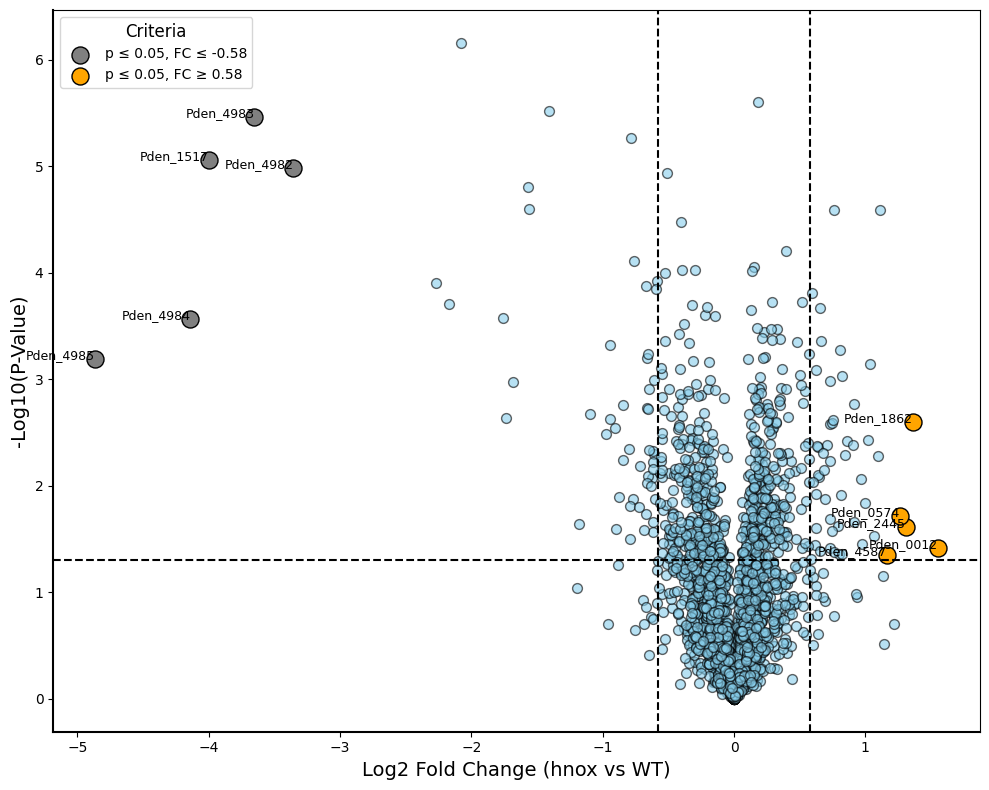

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import re

url = 'https://raw.githubusercontent.com/Thathmi90/MOLBIO-550_Project2/refs/heads/main/Global%20difference_data%20for%20PCA%20plot.csv'
df = pd.read_csv(url)
df.head()

# Calculate mean for WT and DM replicates
df['WT_Mean'] = df[['WT_1', 'WT_2', 'WT_3']].mean(axis=1)
df['hnox_Mean'] = df[['hnox_1', 'hnox_2', 'hnox_3']].mean(axis=1)

# Calculate log2 fold-change
#df['Log2_FC'] = np.log2(df['hnox_Mean'] / df['WT_Mean'].replace(0, np.nan)) (the values are already log transformed, so i have not used this)
df['Log2_FC'] = (df['hnox_Mean'] - df['WT_Mean'].replace(0, np.nan))


# Perform t-tests (two-sample assuming equal variance)
t_stats, p_values = ttest_ind(
    df[['WT_1', 'WT_2', 'WT_3']].values,
    df[['hnox_1', 'hnox_2', 'hnox_3']].values,
    axis=1, nan_policy='omit'
)

# Add p-values and -log10(p-values) to the DataFrame
df['P_Value'] = p_values
df['MinusLog10_P'] = -np.log10(df['P_Value'])

# Filter for statistically significant genes (P_Value < 0.05)
# Also drop any rows where P_Value or Log2_FC might be NaN to ensure clean selection
significant_and_clean_genes = df.dropna(subset=['P_Value', 'Log2_FC'])
significant_and_clean_genes = significant_and_clean_genes[significant_and_clean_genes['P_Value'] < 0.05]

# Select top 5 down-regulated genes from the significant set
down_regulated = significant_and_clean_genes.nsmallest(5, 'Log2_FC')

# Select top 5 up-regulated genes from the significant set
up_regulated = significant_and_clean_genes.nlargest(5, 'Log2_FC')

# Concatenate the top down and up-regulated genes
top_genes = pd.concat([down_regulated, up_regulated])


# Separate significant genes for coloring
left_candidates = top_genes[top_genes['Log2_FC'] < -0.58]
right_candidates = top_genes[top_genes['Log2_FC'] >= 0.58]

# Explicitly remove NaNs from right_candidates before plotting
right_candidates = right_candidates.dropna(subset=['Log2_FC', 'MinusLog10_P'])


# Create the volcano plot
plt.figure(figsize=(10, 8))
plt.scatter(df['Log2_FC'], df['MinusLog10_P'], alpha=0.6, edgecolor='black', marker='o', s=50, color='#87CEEB')

# Highlight significant genes
plt.scatter(left_candidates['Log2_FC'], left_candidates['MinusLog10_P'], color='grey', s=150, edgecolor='black', marker='o', label='p ≤ 0.05, FC ≤ -0.58')
plt.scatter(right_candidates['Log2_FC'], right_candidates['MinusLog10_P'], color='orange', s=150, edgecolor='black', marker='o', label='p ≤ 0.05, FC ≥ 0.58')

# Add gene labels
for _, row in top_genes.iterrows():
    plt.text(row['Log2_FC'], row['MinusLog10_P'], row['Gene'], fontsize=9, ha='right')

# Add reference lines
plt.axhline(-np.log10(0.05), color='black', linestyle='--')
plt.axvline(0.58, color='black', linestyle='--')
plt.axvline(-0.58, color='black', linestyle='--')

# Add a border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Update axis labels and add legend
plt.xlabel('Log2 Fold Change (hnox vs WT)', fontsize=14)
plt.ylabel('-Log10(P-Value)', fontsize=14)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
plt.tight_layout()
# Show the plot
plt.show()

In [9]:
print("Top 5 Down-Regulated Genes (Mean Values):")
display(down_regulated[['Gene', 'WT_Mean', 'hnox_Mean', 'Log2_FC', 'P_Value']])

print("\nTop 5 Up-Regulated Genes (Mean Values):")
display(up_regulated[['Gene', 'WT_Mean', 'hnox_Mean', 'Log2_FC', 'P_Value']])

Top 5 Down-Regulated Genes (Mean Values):


,Gene,WT_Mean,hnox_Mean,Log2_FC,P_Value
2618,Pden_4985,15.671906,10.807692,-4.864214,0.000638
2617,Pden_4984,14.802870,10.662015,-4.140856,0.000270
743,Pden_1517,17.063320,13.063642,-3.999678,0.000009
2616,Pden_4983,17.278977,13.626799,-3.652178,0.000003
2615,Pden_4982,17.728345,14.373179,-3.355166,0.000010



Top 5 Up-Regulated Genes (Mean Values):


,Gene,WT_Mean,hnox_Mean,Log2_FC,P_Value
11,Pden_0012,16.771469,18.323952,1.552483,0.038438
916,Pden_1862,13.445695,14.805792,1.360097,0.002484
1311,Pden_2445,10.383452,11.690518,1.307066,0.024460
264,Pden_0574,17.155499,18.416204,1.260706,0.019346
2440,Pden_4587,9.638482,10.800232,1.161750,0.044498
